In [1]:
import wikipediaapi
import requests
import random
import math

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Crawl a real-world dataset

## Data Source:
The data was sourced from Wikipedia using the `requests` library and the `wikipediaapi`. 

## Variables of Interest:
I mainly focused on 

In [2]:
class WikiDataCrawl:
    def __init__(self):
        self.__user_agent = "Wikipedia_Data_Analytics (nv22224@bristol.ac.uk)"
        self.__titles = []
        self.__wiki_data = pd.DataFrame(columns=['Title','Sumary', 'Sumary Length','Sumary Word Count','Sections Length',
                                                 'Text Length', 'Word Count',
                                                 'Language Count', 'Pageviews'])
        
    def get_wikipedia_page_info(self, title: str):
        # Create a Wikipedia API object
        wiki_wiki = wikipediaapi.Wikipedia(self.__user_agent, 'en')

        # Obtain a page object
        page = wiki_wiki.page(title)

        if not page.exists():
            return None

        # Obtain the length and word count of the page
        page_length = len(page.text)
        page_word_count = len(page.text.split())

        # Construct an API URL to retrieve Wikipedia page information
        api_url = f"https://en.wikipedia.org/w/api.php?action=query&format=json&titles={title}&prop=info|pageviews"
        response = requests.get(api_url)
        data = response.json()

        # Obtain the language count of the page 
        langlinks = page.langlinks
        language_count = len(langlinks)

        try:
            # Obtain the page views
            page_info = data["query"]["pages"]
            page_id = list(page_info.keys())[0]
            pageviews = page_info[page_id]["pageviews"]
            
        except KeyError:
            return None


        # Create a dictionary for storing page information.
        page_data = {
            "Title": page.title,
            "Sumary": page.summary[:100],
            "Sumary Length": len(page.summary),
            "Sumary Word Count": len(page.summary.split()),
            "Sections Length": len(page.sections),
            "Text Length": page_length,
            "Word Count": page_word_count,
            "Language Count": language_count + 1, # English page itself should be included
            "Pageviews": pageviews
        }
        return page_data
    
    def get_random_wikipedia_titles(self, title_nums=150):
        api_url = f"https://en.wikipedia.org/w/api.php?action=query&format=json&list=random&rnnamespace=0&rnlimit={title_nums}"
        response = requests.get(api_url)
        data = response.json()

        # Obtain the title list
        self.__titles = [page['title'] for page in data['query']['random']]

        return self.__titles 
    
    def __call__(self, title_nums):
        
        title_list = self.get_random_wikipedia_titles(title_nums) 
        
        for title in title_list:
            page_data = self.get_wikipedia_page_info(title)
            if page_data is not None:
                self.__wiki_data.loc[len(self.__wiki_data)] = page_data
        
        return self.__wiki_data

In [3]:
# wiki_data_crawl = WikiDataCrawl()
# wiki_data = wiki_data_crawl(600)
# wiki_data.to_csv('wiki_data.csv', index=False)

# Step 2: Perform data preparation & cleaning

In [4]:
wiki_data = pd.read_csv("wiki_data.csv")
wiki_data.rename(columns={"Sumary": "Summary", "Sumary Length": "Summary Length",
                          "Sumary Word Count": "Summary Word Count"}, inplace=True)

## Check whether the dataset has any missing value

In [5]:
display(wiki_data.head(10))
print("===========================================================================================================")
print(f"wiki_data's shape is {wiki_data.shape}")
print("===========================================================================================================")
display(wiki_data.info())

,Title,Summary,Summary Length,Summary Word Count,Sections Length,Text Length,Word Count,Language Count,Pageviews
0,Frederick August Baumbach,Frederick August Baumbach (1753 – 30 November ...,1725,267,0,1725,267,4,"{'2023-10-26': None, '2023-10-27': 1, '2023-10..."
1,The Rat Trap,The Rat Trap (1918) is a four-act drama by Noë...,397,73,8,4439,749,1,"{'2023-10-26': 4, '2023-10-27': 6, '2023-10-28..."
2,Find Another Way,"""Find Another Way"" is a song by German musicia...",246,42,6,1332,224,3,"{'2023-10-26': 3, '2023-10-27': 1, '2023-10-28..."
3,Pteriomorphia,The Pteriomorphia comprise a subclass of saltw...,719,105,4,3869,518,28,"{'2023-10-26': 22, '2023-10-27': 35, '2023-10-..."
4,Danielle Bunten Berry,"Danielle Bunten Berry (February 19, 1949 – Jul...",548,96,11,11283,1913,11,"{'2023-10-26': 58, '2023-10-27': 43, '2023-10-..."
5,City Lights,City Lights is a 1931 American silent romantic...,1805,292,8,27890,4750,53,"{'2023-10-26': 428, '2023-10-27': 506, '2023-1..."
6,Eliza A. Dupuy,"Eliza Ann Dupuy (c. 1814 – December 29, 1880) ...",895,149,5,6433,1037,1,"{'2023-10-26': 0, '2023-10-27': 1, '2023-10-28..."
7,El-Gendi Fortress,The El-Gendi Fortress (Arabic: قلعة الجندي) is...,458,67,3,680,100,6,"{'2023-10-26': 3, '2023-10-27': 20, '2023-10-2..."
8,Bądzsław,Bądzsław [ˈbɔ̃tswaf] is a masculine Old Polish...,196,34,0,196,34,2,"{'2023-10-26': None, '2023-10-27': 0, '2023-10..."
9,Acceptance discography,"The discography of Acceptance, an American alt...",135,20,2,199,29,1,"{'2023-10-26': 4, '2023-10-27': 2, '2023-10-28..."


wiki_data's shape is (499, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499 entries, 0 to 498
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Title               499 non-null    object
 1   Summary             499 non-null    object
 2   Summary Length      499 non-null    int64 
 3   Summary Word Count  499 non-null    int64 
 4   Sections Length     499 non-null    int64 
 5   Text Length         499 non-null    int64 
 6   Word Count          499 non-null    int64 
 7   Language Count      499 non-null    int64 
 8   Pageviews           499 non-null    object
dtypes: int64(6), object(3)
memory usage: 35.2+ KB


None

In [6]:
wiki_data["Pageviews"] = wiki_data["Pageviews"].apply(lambda x: eval(x))

## Create new features

In [7]:
def dict_average(dictionary: dict):
    # Check if dictionary is null
    if dictionary is None:
        return None  

    # Filter null value
    valid_values = [value for value in dictionary.values() if value is not None]
    
    # Check if all values are null
    if valid_values is None:
        return None  

    # Calculate the average
    average = round((sum(valid_values) / len(valid_values)))
    return average

def dict_max(dictionary: dict):
    
    value_set = set()
    
    for value in dictionary.values():
        if value is not None:
            value_set.add(value)
            
    if value_set is not None:
        return max(value_set)
    else:
        return None

wiki_data["Average Pageviews"] = wiki_data["Pageviews"].apply(dict_average)
wiki_data["Max Pageviews"] = wiki_data["Pageviews"].apply(dict_max)

In [8]:
wiki_data.drop(columns=["Pageviews"],axis=1,inplace=True)
wiki_data["Summary Content Ratio(%)"] = round(wiki_data["Summary Word Count"]/wiki_data["Word Count"] * 100, 2)

In [9]:
wiki_data["Only Summary"] = wiki_data["Summary Content Ratio(%)"].apply(lambda x: 1 if x==100.00 else 0) # If the page only has summary

In [10]:
wiki_data.head()

,Title,Summary,Summary Length,Summary Word Count,Sections Length,Text Length,Word Count,Language Count,Average Pageviews,Max Pageviews,Summary Content Ratio(%),Only Summary
0,Frederick August Baumbach,Frederick August Baumbach (1753 – 30 November ...,1725,267,0,1725,267,4,1,4,100.00,1
1,The Rat Trap,The Rat Trap (1918) is a four-act drama by Noë...,397,73,8,4439,749,1,7,19,9.75,0
2,Find Another Way,"""Find Another Way"" is a song by German musicia...",246,42,6,1332,224,3,3,11,18.75,0
3,Pteriomorphia,The Pteriomorphia comprise a subclass of saltw...,719,105,4,3869,518,28,172,4317,20.27,0
4,Danielle Bunten Berry,"Danielle Bunten Berry (February 19, 1949 – Jul...",548,96,11,11283,1913,11,45,96,5.02,0


## Step 3: Perform exploratory analysis

In [11]:
numerical_columns = ['Summary Length', 'Summary Word Count',
       'Sections Length', 'Text Length', 'Word Count', 'Language Count',
       'Average Pageviews', 'Max Pageviews', 'Summary Content Ratio(%)']
wiki_data_numerical = wiki_data.loc[:,numerical_columns]

In [12]:
wiki_data_numerical_statistics = wiki_data_numerical.describe().T
sum_column = pd.Series(wiki_data_numerical.sum(), name="sum")
wiki_data_numerical_statistics = pd.concat([wiki_data_numerical_statistics, sum_column], axis=1)
wiki_data_numerical_statistics["count"] = wiki_data_numerical_statistics["count"].astype(int)
wiki_data_numerical_statistics["mean"] = wiki_data_numerical_statistics["mean"].apply(lambda x: round(x, 2))
wiki_data_numerical_statistics["std"] = wiki_data_numerical_statistics["std"].apply(lambda x: round(x, 2))
display(wiki_data_numerical_statistics)

,count,mean,std,min,25%,50%,75%,max,sum
Summary Length,499,479.29,509.44,17.00,175.50,311.00,548.50,4251.0,239165.00
Summary Word Count,499,76.66,79.72,4.00,28.00,50.00,88.00,684.0,38253.00
Sections Length,499,3.59,3.24,0.00,1.00,3.00,5.00,28.0,1791.00
Text Length,499,3198.59,5501.65,70.00,444.50,1190.00,3378.50,46962.0,1596094.00
Word Count,499,507.35,858.47,11.00,70.50,195.00,522.00,6988.0,253168.00
Language Count,499,5.98,9.45,1.00,1.00,3.00,7.00,130.0,2985.00
Average Pageviews,499,43.31,319.97,0.00,1.00,2.00,9.00,6360.0,21612.00
Max Pageviews,499,128.68,766.06,0.00,3.00,9.00,26.50,13252.0,64210.00
Summary Content Ratio(%),499,44.94,37.44,0.29,9.43,30.64,87.94,100.0,22427.04


In [13]:
wiki_data_numerical.sample(20)

,Summary Length,Summary Word Count,Sections Length,Text Length,Word Count,Language Count,Average Pageviews,Max Pageviews,Summary Content Ratio(%)
106,187,31,4,685,112,1,1,3,27.68
22,246,33,1,301,41,1,0,2,80.49
234,299,50,4,726,107,1,12,30,46.73
298,159,23,9,837,130,4,1,4,17.69
494,153,25,2,2885,460,6,1,6,5.43
278,378,66,4,975,156,2,1,3,42.31
370,249,39,4,1517,258,3,1,6,15.12
163,130,22,1,147,24,2,0,1,91.67
258,200,29,8,3213,507,8,4,10,5.72
260,136,25,4,1068,186,4,0,2,13.44


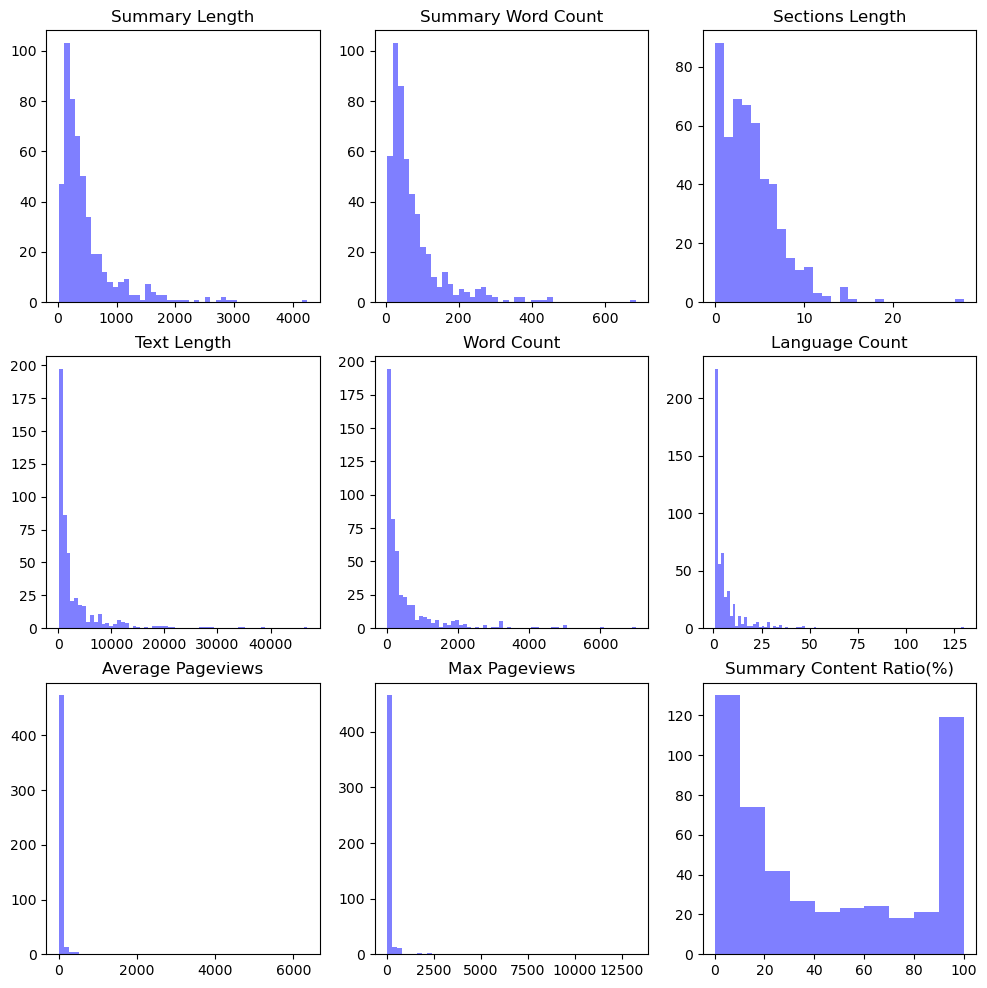

In [14]:
index = 0
wiki_data_numerical_columns = list(wiki_data_numerical.columns)
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 12))


for i in range(3):
    for j in range(3):
        title = wiki_data_numerical_columns[index]
        
        data = wiki_data_numerical[title]
        
        if "Pageviews" not in title:
            axes[i, j].hist(x=data, bins='auto', color='blue', alpha=0.5)
        else:
            axes[i, j].hist(x=data, bins=50, color='blue', alpha=0.5)
        axes[i, j].set_title(f"{title}")
        index += 1

Text(0, 0.5, 'Summary Length')

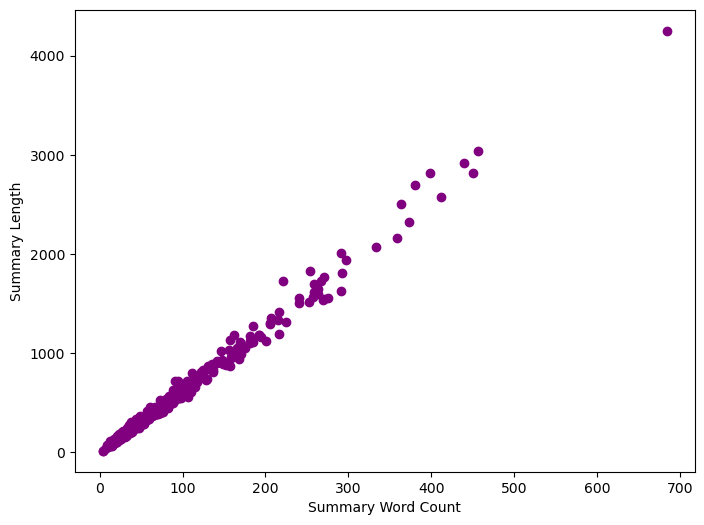

In [15]:
fig, ax = plt.subplots(figsize=(8, 6))
x = wiki_data_numerical["Summary Word Count"]
y = wiki_data_numerical["Summary Length"]
ax.scatter(x,y,marker='o',color='purple')
ax.set_xlabel("Summary Word Count")
ax.set_ylabel("Summary Length")

Text(0, 0.5, 'Language Count')

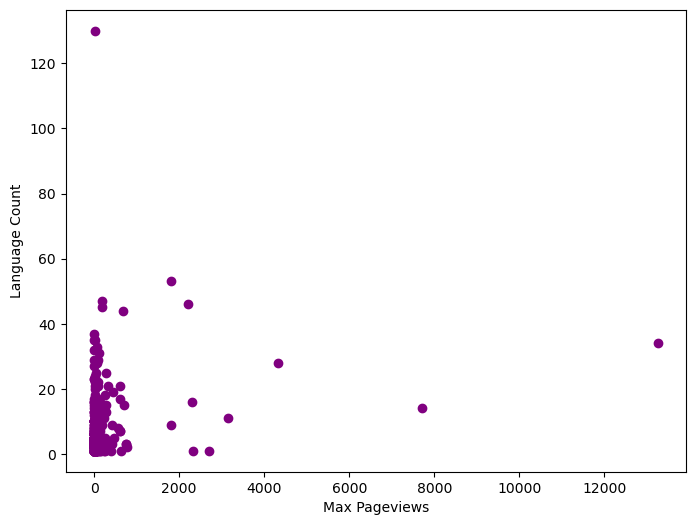

In [16]:
fig, ax = plt.subplots(figsize=(8, 6))
x = wiki_data_numerical["Max Pageviews"]
y = wiki_data_numerical["Language Count"]
ax.scatter(x,y,marker='o',color='purple')
ax.set_xlabel("Max Pageviews")
ax.set_ylabel("Language Count")

Text(0, 0.5, 'Max Pageviews')

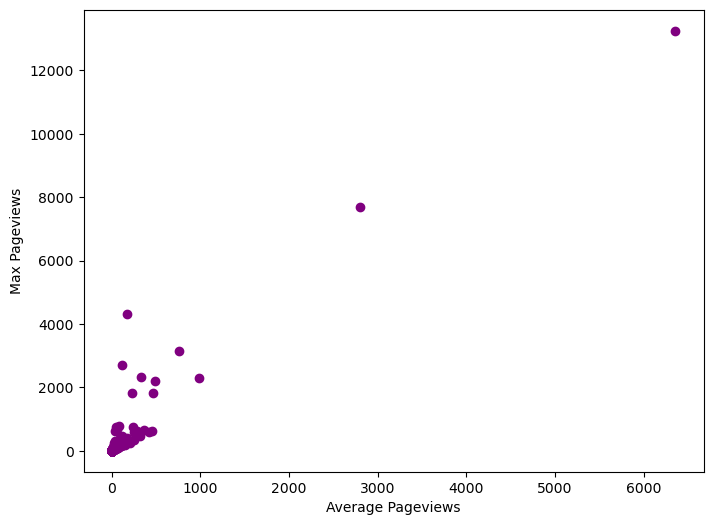

In [17]:
fig, ax = plt.subplots(figsize=(8, 6))
x = wiki_data_numerical["Average Pageviews"]
y = wiki_data_numerical["Max Pageviews"]
ax.scatter(x,y,marker='o',color='purple')
ax.set_xlabel("Average Pageviews")
ax.set_ylabel("Max Pageviews")

Text(0, 0.5, 'Sections Length')

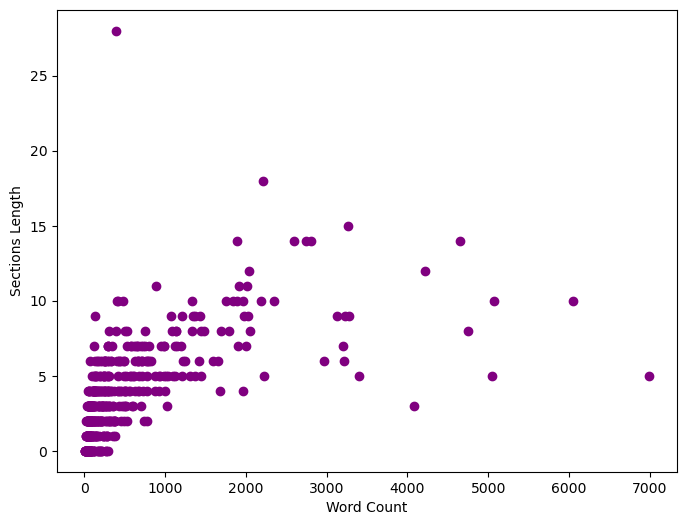

In [18]:
fig, ax = plt.subplots(figsize=(8, 6))
x = wiki_data_numerical["Word Count"]
y = wiki_data_numerical["Sections Length"]
ax.scatter(x,y,marker='o',color='purple')
ax.set_xlabel("Word Count")
ax.set_ylabel("Sections Length")

In [19]:
wiki_data_numerical.columns

Index(['Summary Length', 'Summary Word Count', 'Sections Length',
       'Text Length', 'Word Count', 'Language Count', 'Average Pageviews',
       'Max Pageviews', 'Summary Content Ratio(%)'],
      dtype='object')

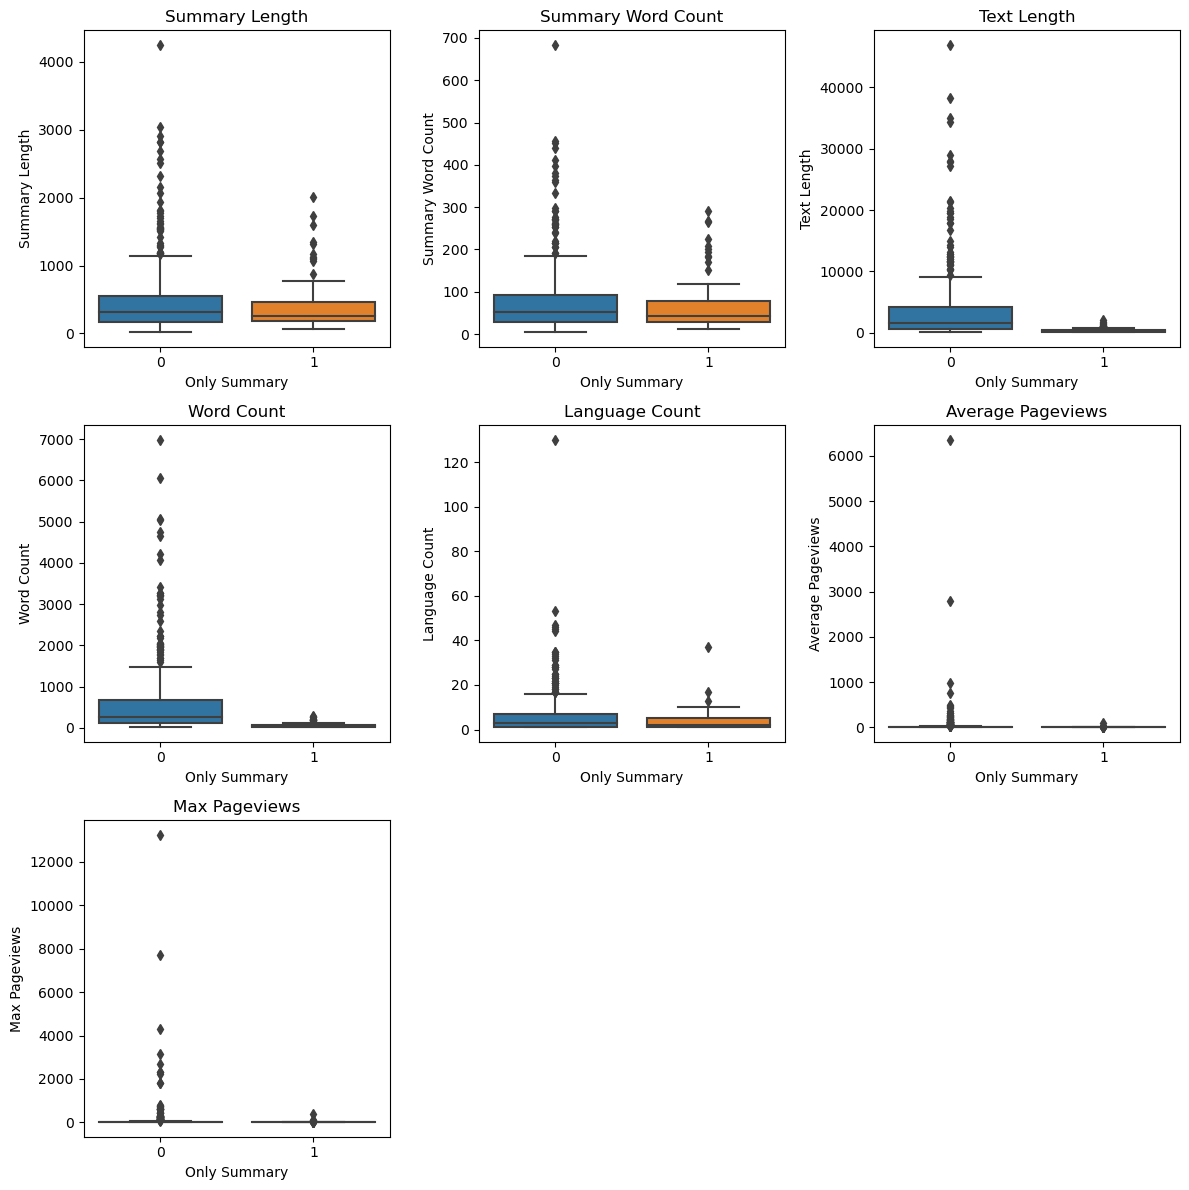

In [20]:
columns = [col for col in wiki_data_numerical.columns if col not in ["Sections Length", "Summary Content Ratio(%)"]]
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 12))

for i, (title, ax) in enumerate(zip(columns, axes.flatten())):
    sns.boxplot(x="Only Summary" , y=title, data=wiki_data, ax=ax)
    ax.set_title(title)
    
axes.flatten()[7].set_visible(False)
axes.flatten()[8].set_visible(False)
    
plt.tight_layout()
plt.show()

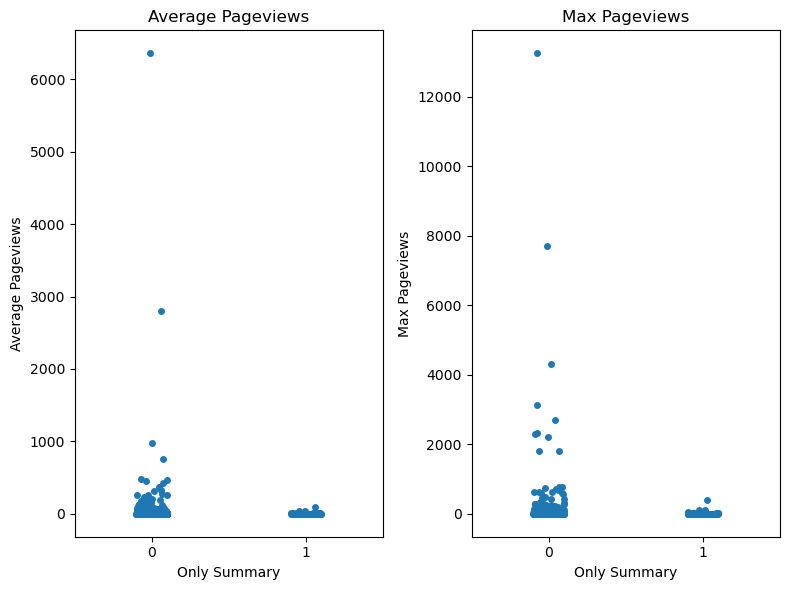

In [21]:
columns = ['Average Pageviews', 'Max Pageviews']
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,6))

for i, (title, ax) in enumerate(zip(columns, axes.flatten())):
    sns.stripplot(x="Only Summary" , y=title, data=wiki_data, ax=ax)
    ax.set_title(title)
    
plt.tight_layout()
plt.show()

# Step 4: Ask questions

## Question a: Is `Sections Length` normally distributed? 

### Shapiro–Wilk test

The Shapiro–Wilk goodness-of-fit test is used to determine if a random sample, $X_i, i=1, 2, ..., n,$ is drawn from a normal Gaussian probability distribution, and the hypothesis is: 
<div style="text-align:center">
$H_0:$ The random sample was drawn from a normal population<br>   
$H_1:$ The random sample was not normal distributed.
</div>

This project will use Shapiro–Wilk test statistic, which is given by:  
$$ W = \frac{\left(\sum_{i=1}^{n} a_i x_{(i)}\right)^2}{\sum_{i=1}^{n} (x_i - \bar{x})^2} $$
where $x_{(i)}$ is the sorted sample value, $\bar{x}$ is the sample mean, and $a_i$ is given by the following formulas:  
$$(a_1, a_2, ..., a_n) =  \frac{m^{T}V^{-1}}{({m^{T}V^{-1}m})^\frac{1}{2}}$$  
where ${(m_1, m_2, ...,m_n)^{T}}$ is the expected values of the ordered statistics that are independent and identically distributed random variables that follow the standard normal, and $V$ is the covariance matrix of the order statistics.

In this project, $\alpha = 0.05$, and we will use `scipy.stats.shapiro` package to calculate $W$ and `p` value.

In [22]:
from scipy.stats import shapiro

In [23]:
W, p_value = shapiro(wiki_data_numerical["Sections Length"])

print(f"Shapiro-Wilk Statistic is {W:.2f}")
print(f"P-value is {p_value:.2f}")

Shapiro-Wilk Statistic is 0.87
P-value is 0.00


According to the result, we should reject $H_0$  as $p < \alpha$, therefore, `Sections Length` is not normally distributed.

## Question b: Is there a linear relationship between `Word Count` and `Text Length`? 

In [24]:
from scipy.stats import pearsonr

In [25]:
x = wiki_data_numerical.loc[:,"Word Count"].to_numpy()
y = wiki_data_numerical.loc[:,"Text Length"].to_numpy()

### Hypothesis Testing:

1. Supposed that $\rho$ represents the population correlation coefficient, The null hypothesis $H_0$ and alternative hypothesis $H_1$ for this test are as follows:
$$H_0: \rho = 0 \\$$
$$H_1: \rho \neq 0$$

2. This test is based on the sample data's calculated correlation coefficient, using the t-statistic to assess whether the sample correlation coefficient is significantly different from zero. The formula for the t-statistic is:
$$t = \frac{r\sqrt[2]{n-2}}{1-r^2} \sim t(n-2)$$
where $r$ reprensts the the sample correlation coefficient and $n$ is the sample size.

3. Set $\alpha = 0.05$ and caculate the `p` value.

In [26]:
pc = pearsonr(x,y)[0]
print(f"Pearson correlation coefficient is {pc}.")

Pearson correlation coefficient is 0.9982001382921664.


In [27]:
p_value = pearsonr(x,y)[1]
print(f"p_value is {p_value:.2f}")

p_value is 0.00


 $p < \alpha$, therefore, $H_0$ should be rejected and that means there is a linear relationship between `Word Count` and `Text Length`.

## Question c: How to predict whether a Wikipedia article only has summary section based on features `Word Count`, `Language Count` and `Average Pageviews`? 

In [28]:
from sklearn.model_selection import train_test_split

Only Summary
0    411
1     88
Name: count, dtype: int64

Text(0, 0.5, 'Count')

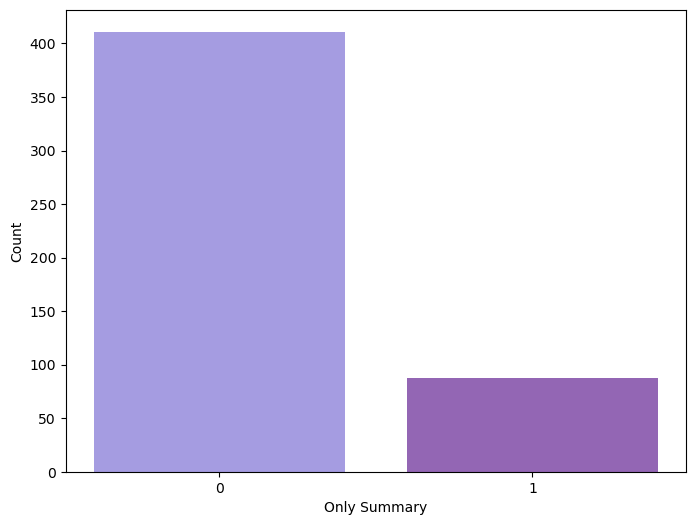

In [29]:
X = wiki_data.loc[:,["Word Count","Language Count","Average Pageviews"]]
y = wiki_data.loc[:,"Only Summary"]
fig, ax = plt.subplots(figsize=(8, 6))
print("=========================")
display(y.value_counts())
print("=========================")

y_labels = [str(i) for i in y.value_counts().index]
y_values = [i for i in y.value_counts().values]
ax.bar(y_labels,y_values,color=["slateblue","indigo"],alpha=0.6)
ax.set_xlabel("Only Summary")
ax.set_ylabel("Count")

### Stratified Sampling

According to the graph above, this dataset is imbalance, therefore, I will apply oversampling method to this dataset.

#### a. Split the dataset

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

#### b. Oversampling the train dataset

In [31]:
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
import optuna

In [32]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

Only Summary
0    329
1    329
Name: count, dtype: int64

Text(0, 0.5, 'Count')

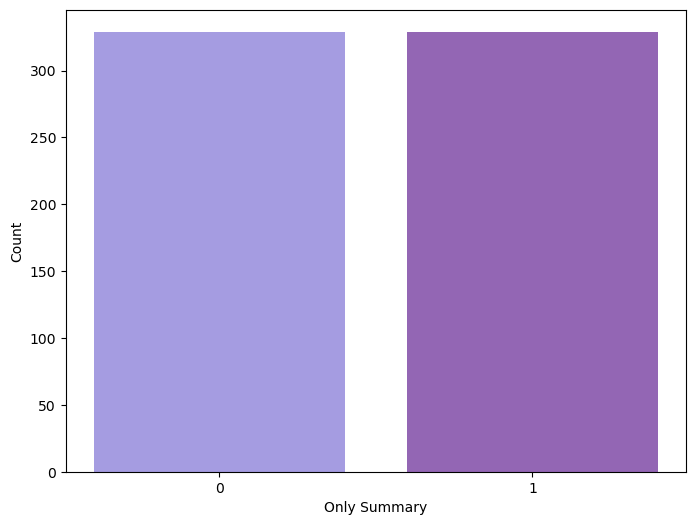

In [33]:
fig, ax = plt.subplots(figsize=(8, 6))

print("=========================")
display(y_resampled.value_counts())
print("=========================")

y_labels = [str(i) for i in y_resampled.value_counts().index]
y_values = [i for i in y_resampled.value_counts().values]
ax.bar(y_labels,y_values,color=["slateblue","indigo"],alpha=0.6)
ax.set_xlabel("Only Summary")
ax.set_ylabel("Count")

### Model trainning

In this part, I choose `Random Forest` as the predicting model.

#### a.  Adjust the hyperparameters

In [49]:
def objective(trial):
    rf_params = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 200),
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
        'max_depth': trial.suggest_int('max_depth', 2, 32, log=True),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'max_features': trial.suggest_float('max_features', 0.1, 1.0),
        'random_state': 42
    }
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    accuracies = []
    for train_index, val_index in kf.split(X_resampled, y_resampled):
        X_train, X_val = X_resampled.iloc[train_index], X_resampled.iloc[val_index]
        y_train, y_val = y_resampled.iloc[train_index], y_resampled.iloc[val_index]

        model = RandomForestClassifier(**rf_params)
        model.fit(X_train, y_train)

        y_pred = model.predict(X_val)
        accuracy = accuracy_score(y_val, y_pred)
        accuracies.append(accuracy)

    return sum(accuracies) / len(accuracies)

In [50]:
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=100)
# trial = study.best_trial

#### b. Apply the best parameters to RandomForestClassifier

In [51]:
# rf_classifier = RandomForestClassifier(**trial.params)
# rf_classifier.fit(X_resampled, y_resampled)

#### c.  Save the model

In [52]:
import pickle

In [53]:
# with open("rf_classifier.pkl", "wb") as f:
#     pickle.dump(rf_classifier, f)

### Model Testing

#### a. Load model

In [56]:
with open("rf_classifier.pkl", "rb") as f:
    rf_classifier = pickle.load(f)

#### b. Obtain the predicting values

In [41]:
y_pred = rf_classifier.predict(X_test)

#### c. Evaluation

In [58]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

In this section, I use five metrics for evaluation, which are `Accuracy`, `Recall`, `Precision`, `F1-Score` and `Confusion Matrix`. And `Accuracy`, `Recall`, `Precision` and `F1-Score` are calculated as the following formulas:
$$Accuracy = \frac{TP + TN}{TP + TN + FP + FN}$$  
$$Recall = \frac{TP}{TP + FN}$$  
$$Precision = \frac{TP}{TP + FP}$$  
$$F1 = \frac{2 \times \text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}$$  
where `TP` (True Positive) is the number of samples that were correctly predicted as positive by the model, `TN` (True Negative) is the number of samples that were correctly predicted as negative by the model, `FP` (False Positive) is the number of samples that were incorrectly predicted as positive by the model when they are actually negative and `FN` (False Negative) is the number of samples that were incorrectly predicted as negative by the model when they are actually positive.

Accuracy is 0.87
F1 score is 0.88
Recall score is 0.94
Precision score is 0.59


Text(0.5, 1.0, 'Confusion Matrix')

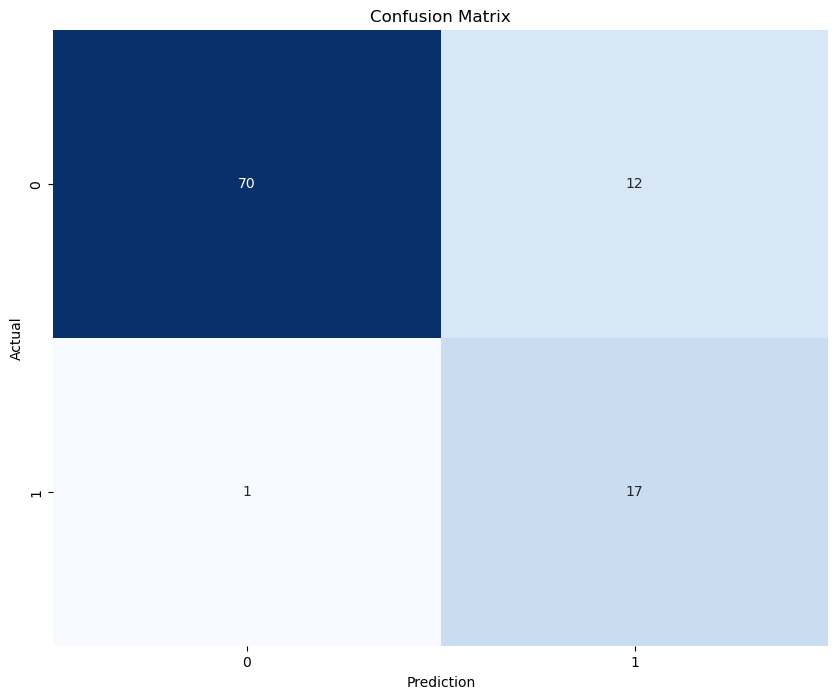

In [47]:
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

print(f"Accuracy is {accuracy:.2f}")
print(f"F1 score is {f1:.2f}")
print(f"Recall score is {recall:.2f}")
print(f"Precision score is {precision:.2f}")

cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
ax.set_xlabel("Prediction")
ax.set_ylabel("Actual")
ax.set_title("Confusion Matrix")

According to the results, 

# Step 5: Summarise and write a conclusion

## Summary

In this project, given the non-profit nature of Wikipedia, reduces the complexity of data acquisition, I use `wikipediaapi` to crawl data from wikipedia. The raw data I obtained is `json`, a non-structed format. For further analysis, I transformed the data into a `DataFrame` format and saved it as a `CSV` file.  
Subsequently, I performed feature engineering on this dataset. I created `Average Pageviews`, `Max Pageviews`, `Summary Content Ratio(%)` and `Only Summary` these four new features and then I used plots to conduct Exploratory Data Analysis (`EDA`).